In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import copy

In [2]:
# Option
dave_mc=False

# Open NCSCD as observation
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]

# Open NCSCD for top 30cm
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_30cm_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
nclu_obs.close()
soc_top_ncscd = soc_ncscd_orig[0,:,:]

# Open NCSCD for sub 70cm
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_70cm_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
nclu_obs.close()
soc_sub_ncscd = soc_ncscd_orig[0,:,:]

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Path
respath='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_1d'
# respath='/data/keeling/a/sshu3/'

if dave_mc:
    contemp='Global_1DSBGC.bgc-yearly-3d_31900.nc'
    preind='Global_1DSBGC.bgc-yearly-3d_1960.nc'
else:
    contemp='2001_2010'
    preind='1861_1870'
mean_mc='mean_mc'
# future_rcp45='rcp45_2091_2100'
# future_rcp85='rcp85_2091_2100'

# Read the 3D files, For ISAM-1D
# Historical
if dave_mc:
    fp=respath+'/'+preind
else:
    fp=respath+'/mean_bgc3d_'+preind+'.nc'
nclu_preind=NetCDFFile(fp,'r')
soclev_preind = nclu_preind.variables['soil_c_lev'][:]
resplev_preind = nclu_preind.variables['resp_lev'][:]
latnc = nclu_preind.variables['lat'][:]
lonnc = nclu_preind.variables['lon'][:]
#lonnc = ((lonnc - 180) % 360) - 180
nclu_preind.close()

# 20th century
if dave_mc:
    fp=respath+'/'+contemp
else:
    fp=respath+'/mean_bgc3d_'+contemp+'.nc'
nclu_contemp=NetCDFFile(fp,'r')
soclev_contemp = nclu_contemp.variables['soil_c_lev'][:]
resplev_contemp = nclu_contemp.variables['resp_lev'][:]
nclu_contemp.close()

# # 21th century - RCP45
# fp=respath+future_rcp45+'/mean_bgc3d_'+future_rcp45+'.nc'
# nclu_rcp45=NetCDFFile(fp,'r')
# soclev_rcp45 = nclu_rcp45.variables['soil_c_lev'][:]
# resplev_rcp45 = nclu_rcp45.variables['resp_lev'][:]
# nclu_rcp45.close()

# # 21th century - RCP85
# fp=respath+future_rcp85+'/mean_bgc3d_'+future_rcp85+'.nc'
# nclu_rcp85=NetCDFFile(fp,'r')
# soclev_rcp85 = nclu_rcp85.variables['soil_c_lev'][:]
# resplev_rcp85 = nclu_rcp85.variables['resp_lev'][:]
# nclu_rcp85.close()

# Read the 3D files, For ISAM-0D
# Also need to plot the ISAM-0D SOC results and NCSCD data to the right side 
# and compare against the mndel outputs
# Seems like the respiration output from 1D model has some problem
# Now let's check the 2D output
respath='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_0d'
if dave_mc:
    contemp='Global_0DSBGC.bgc-yearly-2d_2009.nc'
    preind='Global_0DSBGC.bgc-yearly-2d_1960.nc'
else:
    contemp='2001_2010'
    preind='1861_1870'
mean_mc='mean_mc'
# future_rcp45='rcp45_2091_2100'
# future_rcp85='rcp85_2091_2100'
# Read the 2D files, For ISAM-0D
# Historical
if dave_mc:
    fp=respath+'/'+preind
else:
    fp=respath+'/mean_bgc2d_'+preind+'.nc'
nclu_preind=NetCDFFile(fp,'r')
soc0d_preind = nclu_preind.variables['soil_c'][:]
resp0d_preind = nclu_preind.variables['resp'][:]
#lonnc = ((lonnc - 180) % 360) - 180
nclu_preind.close()

# 20th century
if dave_mc:
    fp=respath+'/'+contemp
else:
    fp=respath+'/mean_bgc2d_'+contemp+'.nc'
nclu_contemp=NetCDFFile(fp,'r')
soc0d_contemp = nclu_contemp.variables['soil_c'][:]
resp0d_contemp = nclu_contemp.variables['resp'][:]
nclu_contemp.close()

# # 21th century - RCP45
# fp=respath+future_rcp45+'/mean_bgc2d_'+future_rcp45+'.nc'
# nclu_rcp45=NetCDFFile(fp,'r')
# soc0d_rcp45 = nclu_rcp45.variables['soil_c'][:]
# resp0d_rcp45 = nclu_rcp45.variables['resp'][:]
# nclu_rcp45.close()

# # 21th century - RCP85
# fp=respath+future_rcp85+'/mean_bgc2d_'+future_rcp85+'.nc'
# nclu_rcp85=NetCDFFile(fp,'r')
# soc0d_rcp85 = nclu_rcp85.variables['soil_c'][:]
# resp0d_rcp85 = nclu_rcp85.variables['resp'][:]
# nclu_rcp85.close()

#temp = soc_ncscd[:, 0:359]
#soc_ncscd[:, 0:359] = soc_ncscd[:, 360:719]
#soc_ncscd[:, 360:719] = temp[:,0:359]
#soc_ncscd[soc0d_contemp<0] = float("nan")

# Open the histel and histosol fraction map to mask peatland 
respath = '/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/'
fhistosol = 'NCSCDv2_Circumpolar_WGS84_histosol_pct_05deg.nc'
fhistel = 'NCSCDv2_Circumpolar_WGS84_histel_pct_05deg.nc'

fp=respath+fhistosol
nclu_his=NetCDFFile(fp,'r')
histosol = nclu_his.variables['NCSCDv2'][:]
latnc3 = nclu_his.variables['lat'][:]
lonnc3 = nclu_his.variables['lon'][:]
frac_histosol = copy.deepcopy(histosol)
histosol[histosol<=0] = 0
histosol[histosol>0] = 1
nclu_his.close()
#histosol = np.flipud(histosol)

fp=respath+fhistel
nclu_his=NetCDFFile(fp,'r')
histel = nclu_his.variables['NCSCDv2'][:]
frac_histel = copy.deepcopy(histel)
histel[histel<=0] = 0
histel[histel>0] = 1
nclu_his.close()

frac_peat = frac_histosol/100. + frac_histel/100.

# Open the spodosol fraction map to mask peatland 
respath = '/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/'
fspodosol = 'global_suborder_halfdeg.nc'

fp=respath+fspodosol
nclu_his=NetCDFFile(fp,'r')
suborder = nclu_his.variables['suborder_05'][:]
latnc4 = nclu_his.variables['y'][:]
lonnc4 = nclu_his.variables['x'][:]
frac_spoosol = copy.deepcopy(suborder)
suborder[suborder<=14] = 0
suborder[suborder>=20] = 0
suborder[suborder>0] = 1
nclu_his.close()
#histosol = np.flipud(histosol)

# Add a new mask with considering peat fraction, spodosol fraction and non-permafrost region
histel_full = ma.zeros((360,720))
histel_full[0:111,:] = histel
temp = copy.deepcopy(histel_full[:, 0:360])
histel_full[:, 0:360] = histel_full[:, 360:720]
histel_full[:, 360:720] = temp
histel_full = histel_full[::-1,:]
temp = copy.deepcopy(suborder[:, 0:360])
suborder[:, 0:360] = suborder[:, 360:720]
suborder[:, 360:720] = temp
suborder = suborder[::-1,:]
notemp_mask = ma.masked_where(histel_full>0, another_mask)
nopeat_mask = ma.masked_where(suborder>0, notemp_mask)

# Get the topsoil SOC (0-30cm) from 1D model
soc_top_preind = np.sum(soclev_preind[0:5,:,:], 0)
soc_top_contemp = np.sum(soclev_contemp[0:5,:,:], 0)
# soc_top_rcp45 = np.sum(soclev_rcp45[0:5,:,:], 0)
# soc_top_rcp85 = np.sum(soclev_rcp85[0:5,:,:], 0)
# topsoil resp
resp_top_preind = np.sum(resplev_preind[0:5,:,:], 0)
resp_top_contemp = np.sum(resplev_contemp[0:5,:,:], 0)
# resp_top_rcp45 = np.sum(resplev_rcp45[0:5,:,:], 0)
# resp_top_rcp85 = np.sum(resplev_rcp85[0:5,:,:], 0)

# Get the subsoil SOC (30-100cm) from 1D model
soc_sub_preind = np.sum(soclev_preind[5:7,:,:], 0)+0.3*soclev_preind[7,:,:]
soc_sub_contemp = np.sum(soclev_contemp[5:7,:,:], 0)+0.3*soclev_contemp[7,:,:]
# soc_sub_rcp45 = np.sum(soclev_rcp45[5:7,:,:], 0)+0.3*soclev_rcp45[7,:,:]
# soc_sub_rcp85 = np.sum(soclev_rcp85[5:7,:,:], 0)+0.3*soclev_rcp85[7,:,:]

# subsoil resp
resp_sub_preind = np.sum(resplev_preind[5:7,:,:], 0)+0.3*resplev_preind[7,:,:]
resp_sub_contemp = np.sum(resplev_contemp[5:7,:,:], 0)+0.3*resplev_contemp[7,:,:]
# resp_sub_rcp45 = np.sum(resplev_rcp45[5:7,:,:], 0)+0.3*resplev_rcp45[7,:,:]
# resp_sub_rcp85 = np.sum(resplev_rcp85[5:7,:,:], 0)+0.3*resplev_rcp85[7,:,:]

# Get the first 1m SOC
# 1D
soc_preind = soc_top_preind + soc_sub_preind
soc_contemp = soc_top_contemp + soc_sub_contemp
# soc_rcp45 = soc_top_rcp45 + soc_sub_rcp45
# soc_rcp85 = soc_top_rcp85 + soc_sub_rcp85

dsoc = soc_contemp - soc_preind
dsoc_topsoil = soc_top_contemp - soc_top_preind
dsoc_subsoil = soc_sub_contemp - soc_sub_preind

# dsoc_rcp45 = soc_rcp45 - soc_contemp
# dsoc_topsoil_rcp45 = soc_top_rcp45 - soc_top_contemp
# dsoc_subsoil_rcp45 = soc_sub_rcp45 - soc_sub_contemp

# dsoc_rcp85 = soc_rcp85 - soc_contemp
# dsoc_topsoil_rcp85 = soc_top_rcp85 - soc_top_contemp
# dsoc_subsoil_rcp85 = soc_sub_rcp85 - soc_sub_contemp

# 0D
dsoc0d = soc0d_contemp - soc0d_preind
dsoc0d[dsoc0d<-3] = 0
dsoc0d_topsoil = 0.3*dsoc0d
dsoc0d_subsoil = 0.7*dsoc0d

# dsoc0d_rcp45 = soc0d_rcp45 - soc0d_contemp
# dsoc0d_rcp85 = soc0d_rcp85 - soc0d_contemp

# resp
# 1D
resp_preind = resp_top_preind + resp_sub_preind
resp_contemp = resp_top_contemp + resp_sub_contemp
# resp_rcp45 = resp_top_rcp45 + resp_sub_rcp45
# resp_rcp85 = resp_top_rcp85 + resp_sub_rcp85

dresp = resp_contemp - resp_preind
# dresp_rcp45 = resp_rcp45 - resp_contemp
# dresp_rcp85 = resp_rcp85 - resp_contemp

# 0D
dresp0d = resp0d_contemp - resp0d_preind
# dresp0d_rcp45 = resp0d_rcp45 - resp0d_contemp
# dresp0d_rcp85 = resp0d_rcp85 - resp0d_contemp

# Get the bulk soil turnover time by calculating the turnover at each layer then calculate C weighted average.
# Get the turnover for each layer
soclev_preind_cp = copy.deepcopy(soclev_preind)
soclev_contemp_cp = copy.deepcopy(soclev_contemp)
# soclev_rcp45_cp = copy.deepcopy(soclev_rcp45)
# soclev_rcp85_cp = copy.deepcopy(soclev_rcp85)

tau_lev_preind = soclev_preind/resplev_preind
tau_lev_contemp = soclev_contemp/resplev_contemp
# tau_lev_rcp45 = soclev_rcp45/resplev_rcp45
# tau_lev_rcp85 = soclev_rcp85/resplev_rcp85

# Anomalous high SOC but low respiration will be ignored.
tau_lev_preind[tau_lev_preind>4000] = 0
tau_lev_contemp[tau_lev_contemp>4000] = 0
# tau_lev_rcp45[tau_lev_rcp45>4000] = 0
# tau_lev_rcp85[tau_lev_rcp85>4000] = 0
soclev_preind_cp[tau_lev_preind<=0] = 0.
soclev_contemp_cp[tau_lev_contemp<=0] = 0.
# soclev_rcp45_cp[tau_lev_rcp45<=0] = 0.
# soclev_rcp85_cp[tau_lev_rcp85<=0] = 0.
soc_preind_cp = np.sum(soclev_preind_cp[0:7,:,:], 0)+0.3*soclev_preind_cp[7,:,:]
soc_contemp_cp = np.sum(soclev_contemp_cp[0:7,:,:], 0)+0.3*soclev_contemp_cp[7,:,:]
# soc_rcp45_cp = np.sum(soclev_rcp45_cp[0:7,:,:], 0)+0.3*soclev_rcp45_cp[7,:,:]
# soc_rcp85_cp = np.sum(soclev_rcp85_cp[0:7,:,:], 0)+0.3*soclev_rcp85_cp[7,:,:]

# Calculate the C mass weights
wt_preind = soclev_preind_cp/soc_preind_cp
wt_contemp = soclev_contemp_cp/soc_contemp_cp
# wt_rcp45 = soclev_rcp45_cp/soc_rcp45_cp
# wt_rcp85 = soclev_rcp85_cp/soc_rcp85_cp

tau_tmp_preind = wt_preind * tau_lev_preind
tau_tmp_contemp = wt_contemp * tau_lev_contemp
# tau_tmp_rcp45 = wt_rcp45 * tau_lev_rcp45
# tau_tmp_rcp85 = wt_rcp85 * tau_lev_rcp85

tau_preind = np.sum(tau_tmp_preind[0:7,:,:], 0)+0.3*tau_tmp_preind[7,:,:]
tau_contemp = np.sum(tau_tmp_contemp[0:7,:,:], 0)+0.3*tau_tmp_contemp[7,:,:]
# tau_rcp45 = np.sum(tau_tmp_rcp45[0:7,:,:], 0)+0.3*tau_tmp_rcp45[7,:,:]
# tau_rcp85 = np.sum(tau_tmp_rcp85[0:7,:,:], 0)+0.3*tau_tmp_rcp85[7,:,:]

dtau = tau_contemp - tau_preind
# dtau_rcp45 = tau_rcp45 - tau_contemp
# dtau_rcp85 = tau_rcp85 - tau_contemp

# 0D
tau0d_preind = soc0d_preind/resp0d_preind
tau0d_contemp = soc0d_contemp/resp0d_contemp
# tau0d_rcp45 = soc0d_rcp45/resp0d_rcp45
# tau0d_rcp85 = soc0d_rcp45/resp0d_rcp85

dtau0d = tau0d_contemp - tau0d_preind
# dtau0d_rcp45 = tau0d_rcp45 - tau0d_contemp
# dtau0d_rcp85 = tau0d_rcp85 - tau0d_contemp

In [ ]:
plt.imshow(suborder)

In [ ]:
plt.imshow(nopeat_mask)

In [3]:
# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent
tau_contemp_perm = copy.deepcopy(tau_contemp)
tau_contemp_perm.mask = another_mask.mask
tau0d_contemp_perm = copy.deepcopy(tau0d_contemp)
tau0d_contemp_perm.mask = another_mask.mask

soc_top_preind_perm = copy.deepcopy(soc_top_preind)
soc_top_preind_perm.mask = another_mask.mask
soc_top_contemp_perm = copy.deepcopy(soc_top_contemp)
soc_top_contemp_perm.mask = another_mask.mask
soc_sub_preind_perm = copy.deepcopy(soc_sub_preind)
soc_sub_preind_perm.mask = another_mask.mask
soc_sub_contemp_perm = copy.deepcopy(soc_sub_contemp)
soc_sub_contemp_perm.mask = another_mask.mask

soc_preind_perm = copy.deepcopy(soc_preind)
soc_preind_perm.mask = another_mask.mask
soc0d_preind_perm = copy.deepcopy(soc0d_preind)
soc0d_preind_perm.mask = another_mask.mask

soc_contemp_perm = copy.deepcopy(soc_contemp)
soc_contemp_perm.mask = another_mask.mask
soc0d_contemp_perm = copy.deepcopy(soc0d_contemp)
soc0d_contemp_perm.mask = another_mask.mask

soc_ncscd_perm = copy.deepcopy(soc_ncscd)
nopeat_mask_new = copy.deepcopy(nopeat_mask)
temp = copy.deepcopy(nopeat_mask_new[:,0:360])
nopeat_mask_new[:,0:360] = nopeat_mask_new[:,360:720]
nopeat_mask_new[:,360:720] = temp
soc_ncscd_perm.mask = nopeat_mask_new.mask

soc_top_ncscd[soc_top_ncscd<0] = 0.
soc_top_ncscd[soc_top_ncscd>200] = 0.
soc_top_ncscd_perm = copy.deepcopy(soc_top_ncscd)
soc_top_ncscd_perm.mask = nopeat_mask_new.mask

soc_sub_ncscd[soc_sub_ncscd<0] = 0.
soc_sub_ncscd[soc_sub_ncscd>200] = 0.
soc_sub_ncscd_perm = copy.deepcopy(soc_sub_ncscd)
soc_sub_ncscd_perm.mask = nopeat_mask_new.mask

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val = np.ones((nlat, nlon))*float("nan")
val_0d = np.ones((nlat, nlon))*float("nan")
val_obs = np.ones((nlat, nlon))*float("nan")
val_top_obs = np.ones((nlat, nlon))*float("nan")
val_sub_obs = np.ones((nlat, nlon))*float("nan")
val_top = np.ones((nlat, nlon))*float("nan")
val_sub = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        # ISAM-1D estimation for 2000s
        val[i,j] = soc_preind_perm[i,j] * grid_area[i,j]
        val_top[i,j] = soc_top_preind_perm[i,j] * grid_area[i,j]
        val_sub[i,j] = soc_sub_preind_perm[i,j] * grid_area[i,j]
        # ISAM-0D estimation for 2000s
        val_0d[i,j] = soc0d_preind_perm[i,j] * grid_area[i,j]
        # NCSCD_v2
        val_obs[i,j] = soc_ncscd_perm[i,j] * grid_area[i,j]
        val_top_obs[i,j] = soc_top_ncscd_perm[i,j] * grid_area[i,j]
        val_sub_obs[i,j] = soc_sub_ncscd_perm[i,j] * grid_area[i,j]
        

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:64: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:65: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:69: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: UserWarning: Warning: converting a masked element 

In [4]:
# Get the total amount of NCSCD SOC by excluding histosol and histel
total_histosol = 69.1
total_histel = 49.3
val_0d[val_0d<0] = 0
isam_0d_all = np.nansum(val_0d)/1e12
isam_1d_all = np.nansum(val)/1e12
top_1d = np.nansum(val_top)/1e12
sub_1d = np.nansum(val_sub)/1e12
top_obs = np.nansum(val_top_obs)/1e12
sub_obs = 327.36 - top_obs

ncscd_all = np.nansum(val_obs)/1e12
ncscd_nopeat = np.nansum(val_obs)/1e12# - total_histosol - total_histel
print('NCSCD SOC stock ...')
print(ncscd_all)
print('NCSCD SOC stock without peat ...')
print(ncscd_nopeat)
print('ISAM-1D estimated SOC stock ...')
print(isam_1d_all)
print('ISAM-0D estimated SOC stock ...')
print(isam_0d_all)
print('==========================')
print('ISAM-0D topsoil SOCS:')
print(isam_0d_all*0.3)
print('ISAM-0D subsoil SOCS:')
print(isam_0d_all*0.7)
print('ISAM-1D topsoil SOCS:')
print(top_1d)
print('ISAM-1D subsoil SOCS:')
print(sub_1d)
print('NCSCD topsoil SOCS:')
print(top_obs)
print('NCSCD subsoil SOCS:')
print(sub_obs)

NCSCD SOC stock ...
327.36339237953393
NCSCD SOC stock without peat ...
327.36339237953393
ISAM-1D estimated SOC stock ...
318.99728261481255
ISAM-0D estimated SOC stock ...
156.9460116865395
ISAM-0D topsoil SOCS:
47.083803505961846
ISAM-0D subsoil SOCS:
109.86220818057764
ISAM-1D topsoil SOCS:
118.62123072958478
ISAM-1D subsoil SOCS:
200.37605188522775
NCSCD topsoil SOCS:
140.61234327329993
NCSCD subsoil SOCS:
186.7476567267001


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [ ]:
# NCSCD SOC stock ...
# 474.9181063795683
# NCSCD SOC stock without peat ...
# 356.51810637956834

# ISAM-1D estimated contemporary SOC stock ...
# 353.52246987372865
# ISAM-0D estimated contemporary SOC stock ...
# 180.7218003115083
# ISAM-1D estimated preindustrail SOC stock ...
# 343.61655160412346
# ISAM-0D estimated preindustrail SOC stock ...
# 177.30753527613672

In [4]:
# ISAM model estimation after considering spodosol mask
# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent
tau_contemp_perm = copy.deepcopy(tau_contemp)
tau_contemp_perm.mask = nopeat_mask.mask
tau0d_contemp_perm = copy.deepcopy(tau0d_contemp)
tau0d_contemp_perm.mask = nopeat_mask.mask

soc_top_preind_perm = copy.deepcopy(soc_top_preind)
soc_top_preind_perm.mask = nopeat_mask.mask
soc_top_contemp_perm = copy.deepcopy(soc_top_contemp)
soc_top_contemp_perm.mask = nopeat_mask.mask
soc_sub_preind_perm = copy.deepcopy(soc_sub_preind)
soc_sub_preind_perm.mask = nopeat_mask.mask
soc_sub_contemp_perm = copy.deepcopy(soc_sub_contemp)
soc_sub_contemp_perm.mask = nopeat_mask.mask

soc_preind_perm = copy.deepcopy(soc_preind)
soc_preind_perm.mask = nopeat_mask.mask
soc0d_preind_perm = copy.deepcopy(soc0d_preind)
soc0d_preind_perm.mask = nopeat_mask.mask

soc_contemp_perm = copy.deepcopy(soc_contemp)
soc_contemp_perm.mask = nopeat_mask.mask
soc0d_contemp_perm = copy.deepcopy(soc0d_contemp)
soc0d_contemp_perm.mask = nopeat_mask.mask

soc0d_top_contemp_perm = soc0d_contemp_perm*0.3
soc0d_sub_contemp_perm = soc0d_contemp_perm*0.7

NameError: name 'soc0d_top_contemp_perm' is not defined

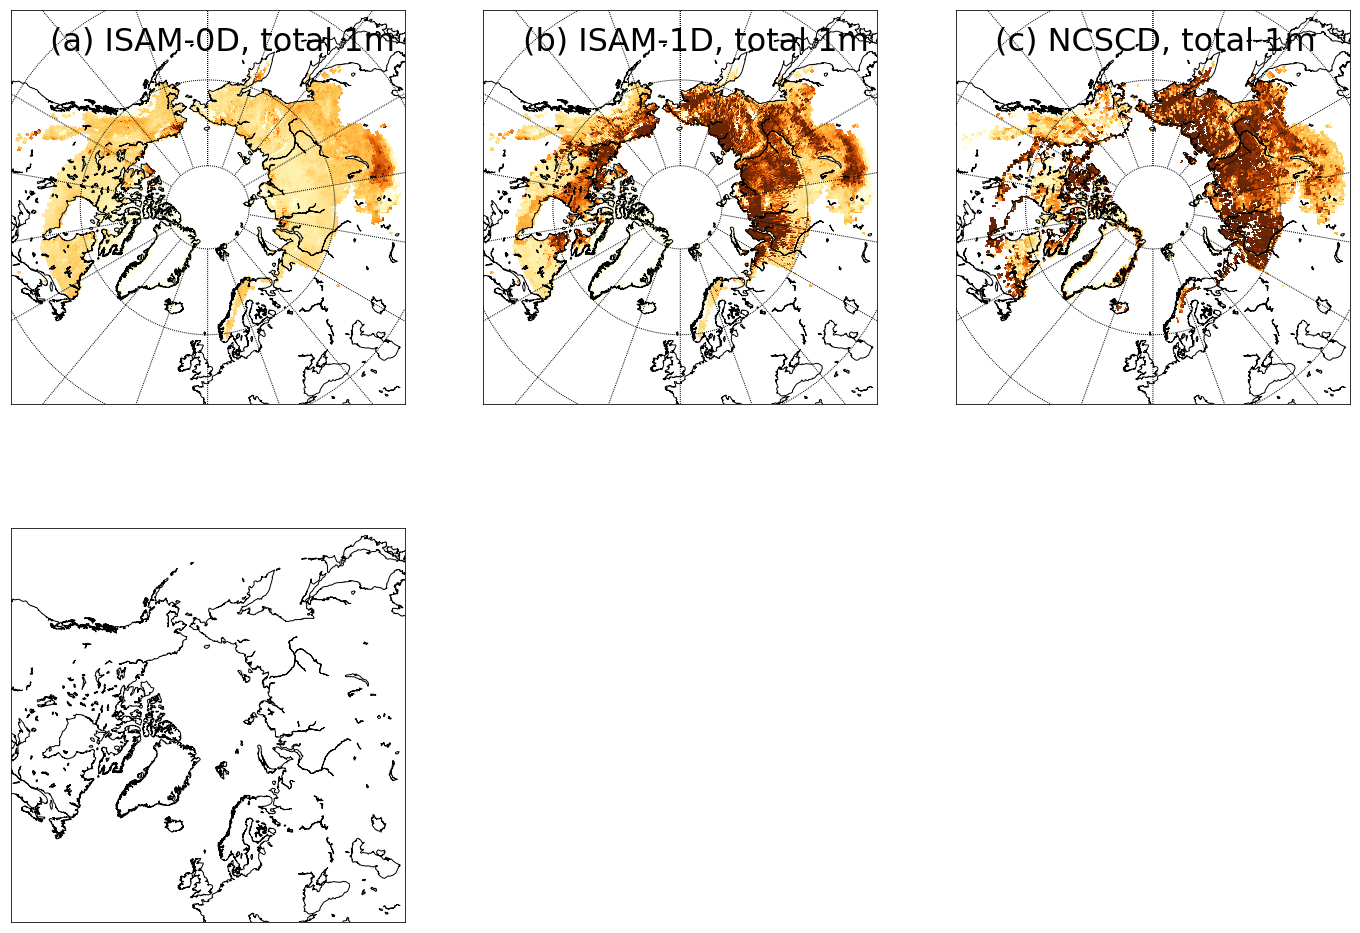

In [5]:
# Plot the figure1
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(24,27))

ax1 = fig.add_subplot(331)
#ax1.set_title("ISAM-0D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc3, latnc3)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,soc0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
# Overlap scatter plot to show the peatland distribution
#map.scatter(xs, ys, s = 4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 4*histel, latlon=True, marker='_', color='cyan')
#cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
plt.annotate('(a) ISAM-0D, total 1m', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.tick_params(labelsize=30) 

ax2 = fig.add_subplot(332)
#ax2.set_title("ISAM-1D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,soc_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=32, labelpad=10)
plt.annotate('(b) ISAM-1D, total 1m', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=30) 

lon2,lat2 = np.meshgrid(lonnc2,latnc2) #Returns coordinate matrices from coordinate vectors
x2,y2 = map(lon2,lat2)
ax2 = fig.add_subplot(333)
#ax2.set_title("NCSCD SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x2,y2,soc_ncscd_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                     # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
plt.annotate('(c) NCSCD, total 1m', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=30) 

ax1 = fig.add_subplot(334)
#ax1.set_title("ISAM-0D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
#lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
#x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc3, latnc3)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,soc0d_top_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
# Overlap scatter plot to show the peatland distribution
#map.scatter(xs, ys, s = 4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 4*histel, latlon=True, marker='_', color='cyan')
#cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
plt.annotate('(d) ISAM-0D, topsoil', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.tick_params(labelsize=30) 

ax2 = fig.add_subplot(335)
#ax2.set_title("ISAM-1D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,soc_top_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=32, labelpad=10)
plt.annotate('(e) ISAM-1D, topsoil', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=30) 

#lon2,lat2 = np.meshgrid(lonnc2,latnc2) #Returns coordinate matrices from coordinate vectors
#x2,y2 = map(lon2,lat2)
ax2 = fig.add_subplot(336)
#ax2.set_title("NCSCD SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x2,y2,soc_top_ncscd_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                     # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
plt.annotate('(f) NCSCD, topsoil', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=30) 

ax1 = fig.add_subplot(337)
#ax1.set_title("ISAM-0D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
#lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
#x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc3, latnc3)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,soc0d_sub_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
# Overlap scatter plot to show the peatland distribution
#map.scatter(xs, ys, s = 4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 4*histel, latlon=True, marker='_', color='cyan')
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
plt.annotate('(g) ISAM-0D, subsoil', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

ax2 = fig.add_subplot(338)
#ax2.set_title("ISAM-1D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,soc_sub_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=32, labelpad=10)
plt.annotate('(h) ISAM-1D, subsoil', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=30) 

#lon2,lat2 = np.meshgrid(lonnc2,latnc2) #Returns coordinate matrices from coordinate vectors
#x2,y2 = map(lon2,lat2)
ax2 = fig.add_subplot(339)
#ax2.set_title("NCSCD SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x2,y2,soc_sub_ncscd_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                     # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
plt.annotate('(i) NCSCD, subsoil', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=30) 


# ax3 = fig.add_subplot(234)
# #ax3.set_title("ISAM-1D SOC turnover time",fontsize=32,pad=15)
# map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# # draw coastlines, state and country boundaries, edge of map.
# map.drawcoastlines()
# #map.drawstates()
# #map.drawcountries(color='b')
# cs = map.pcolormesh(x,y,tau0d_contemp_perm[:,:],
#               norm=colors.LogNorm(vmin=1,vmax=1500.),cmap=plt.cm.summer) # use log color scale,
#                                                       # omit this to use linear
#                                                      # color scale
# cbar = map.colorbar(cs,ticks=[1, 10, 100, 1000, 5000],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
# plt.annotate('(a) ISAM-0D', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
# #cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
# map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
# map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
# cbar.ax.tick_params(labelsize=30) 

# ax3 = fig.add_subplot(235)
# #ax3.set_title("ISAM-0D SOC turnover time",fontsize=32,pad=15)
# map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# # draw coastlines, state and country boundaries, edge of map.
# map.drawcoastlines()
# #map.drawstates()
# #map.drawcountries(color='b')
# cs = map.pcolormesh(x,y,tau_contemp_perm[:,:],
#               norm=colors.LogNorm(vmin=1,vmax=1500.),cmap=plt.cm.summer) # use log color scale,
#                                                       # omit this to use linear
#                                                      # color scale
# cbar = map.colorbar(cs,ticks=[1, 10, 100, 1000, 5000],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
# cbar.ax.set_xlabel('Unit: year', fontsize=32, labelpad=10)
# plt.annotate('(b) ISAM-1D', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
# #cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
# map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
# map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
# cbar.ax.tick_params(labelsize=30)

plt.tight_layout()
#plt.show()
plt.savefig('./figures/fig6.png',dpi=300)

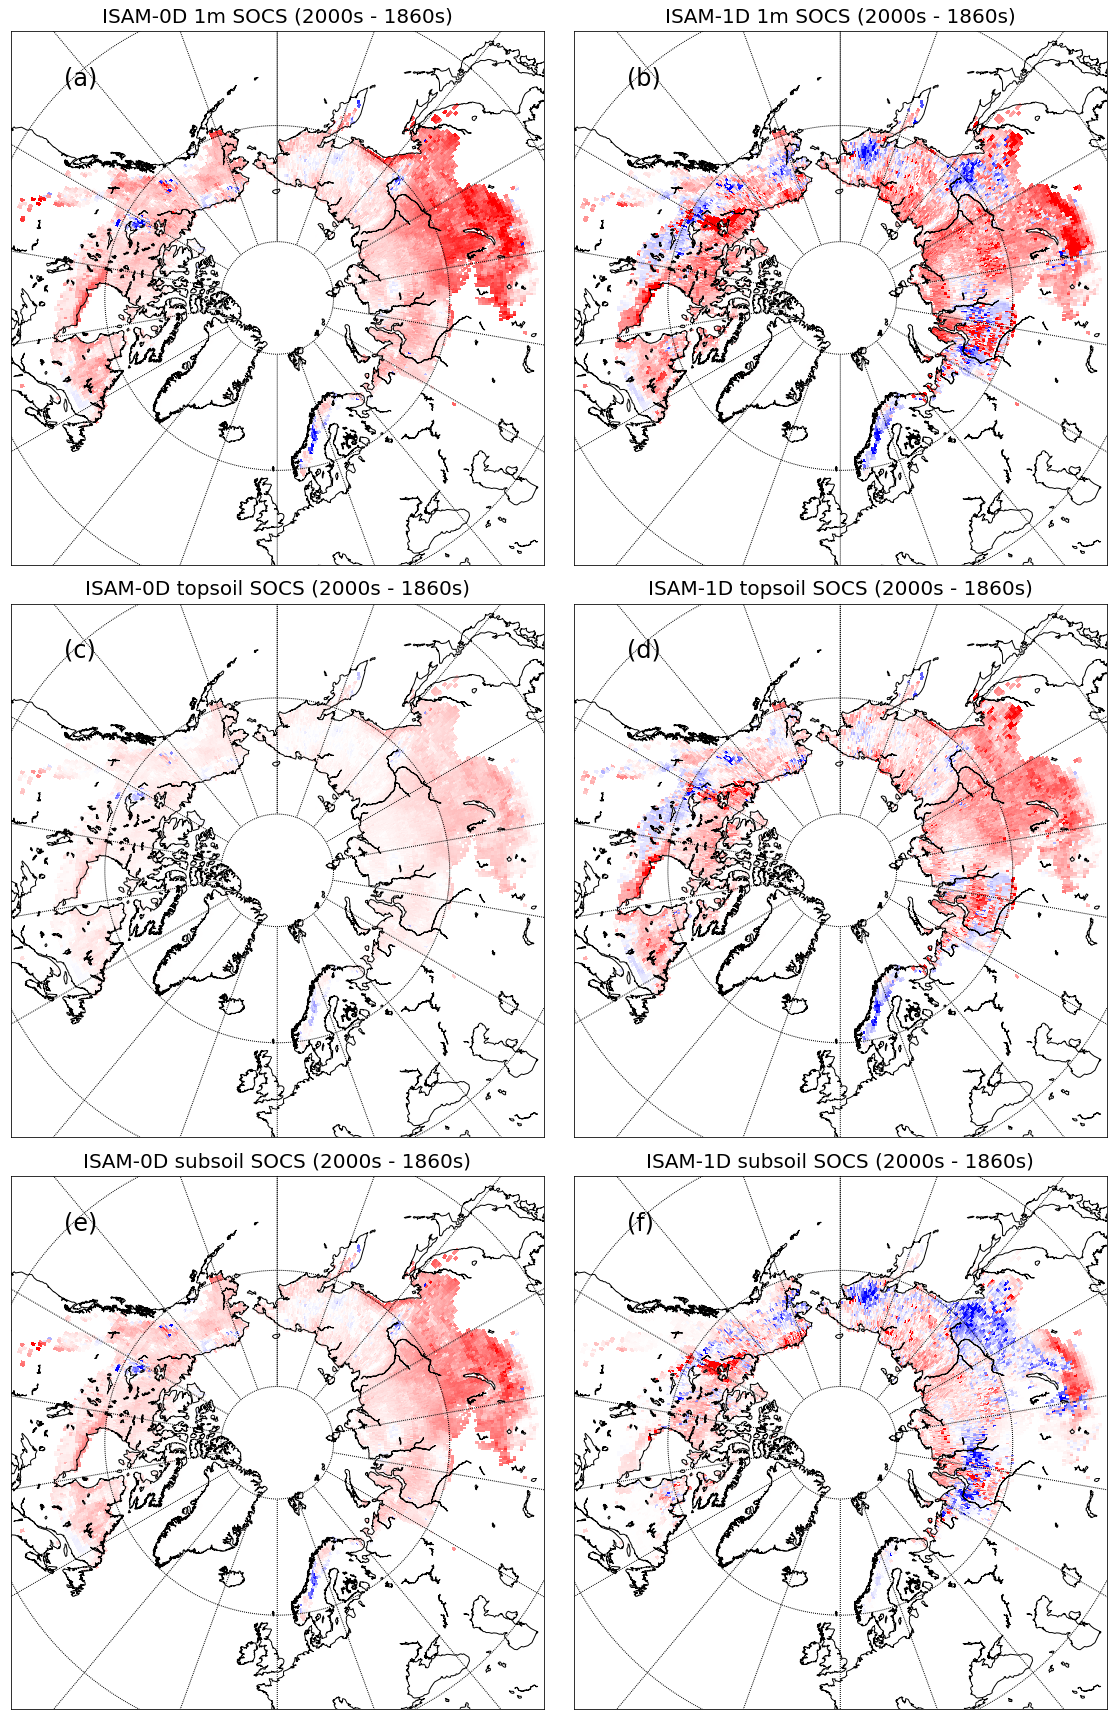

In [6]:
# Mask all regions outside the northern permafrost extent
dsoc_perm = copy.deepcopy(dsoc)
dsoc_perm.mask = another_mask.mask
dsoc_top_perm = copy.deepcopy(dsoc_topsoil)
dsoc_top_perm.mask = another_mask.mask
dsoc_sub_perm = copy.deepcopy(dsoc_subsoil)
dsoc_sub_perm.mask = another_mask.mask

dsoc0d_perm = copy.deepcopy(dsoc0d)
dsoc0d_perm.mask = another_mask.mask
dsoc0d_top_perm = copy.deepcopy(dsoc0d_topsoil)
dsoc0d_top_perm.mask = another_mask.mask
dsoc0d_sub_perm = copy.deepcopy(dsoc0d_subsoil)
dsoc0d_sub_perm.mask = another_mask.mask

dtau_perm = copy.deepcopy(dtau)
dtau_perm.mask = another_mask.mask
dtau0d_perm = copy.deepcopy(dtau0d)
dtau0d_perm.mask = another_mask.mask

# Mask the strange results around greenland

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(16,24))

#ax1 = fig.add_subplot(331)
ax1 = fig.add_subplot(321)
ax1.set_title("ISAM-0D 1m SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,dsoc0d_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
#cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(322)
ax2.set_title("ISAM-1D 1m SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,dsoc_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax3 = fig.add_subplot(323)
ax3.set_title("ISAM-0D topsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dsoc0d_top_perm[:,:],
#              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(324)
ax4.set_title("ISAM-1D topsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
#              norm=colors.Normalize(vmin=-60.,vmax=60.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,

#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax3 = fig.add_subplot(325)
ax3.set_title("ISAM-0D subsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dsoc0d_sub_perm[:,:],
#              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(e)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=18) 

ax4 = fig.add_subplot(326)
ax4.set_title("ISAM-1D subsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
#              norm=colors.Normalize(vmin=-60.,vmax=60.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=16, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(f)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
#plt.show()
plt.savefig('./figures/fig8_wt_cb.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

#plt.show()
plt.savefig('./figures/fig9.png',dpi=300)

In [ ]:
# Plot the figure3
# Mask all regions outside the northern permafrost extent
resp_contemp_perm = copy.deepcopy(resp_contemp)
resp_contemp_perm.mask = another_mask.mask
resp0d_contemp_perm = copy.deepcopy(resp0d_contemp)
resp0d_contemp_perm.mask = another_mask.mask
resp_preind_perm = copy.deepcopy(resp_preind)
resp_preind_perm.mask = another_mask.mask
resp0d_preind_perm = copy.deepcopy(resp0d_preind)
resp0d_preind_perm.mask = another_mask.mask
dresp_perm = copy.deepcopy(dresp)
dresp_perm.mask = another_mask.mask
dresp0d_perm = copy.deepcopy(dresp0d)
dresp0d_perm.mask = another_mask.mask

# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig10.jpg',dpi=300)

In [ ]:
lonnc2

In [ ]:
lonnc2 % 360
